Author: Hem N Chaudhary

Date: Jan, 2024

Description: Dealing with No Labels. Automating tagging issue with metadata based on the issue's description.

In [ ]:
#Getting the Data from "https://git.io/nlp-with-transformers"

import pandas as pd

dataset_url = "https://git.io/nlp-with-transformers"

df_issues = pd.read_json(dataset_url, lines=True)
print(f"DataFrame shape: {df_issues.shape}")

DataFrame shape: (9930, 26)


In [ ]:
df_issues.head(1)

,url,repository_url,labels_url,comments_url,events_url,html_url,id,node_id,number,title,...,milestone,comments,created_at,updated_at,closed_at,author_association,active_lock_reason,body,performed_via_github_app,pull_request
0,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://github.com/huggingface/transformers/is...,849568459,MDU6SXNzdWU4NDk1Njg0NTk=,11046,Potential incorrect application of layer norm ...,...,NaN,0,2021-04-03 03:37:32,2021-04-03 03:37:32,NaT,NONE,None,"In BlenderbotSmallDecoder, layer norm is appl...",NaN,None


In [ ]:
#selecting a couple of columns to took at

cols = ["url", "id", "title", "user", "labels", "state", "created_at", "body"]
df_issues.loc[2, cols].to_frame()

,2
url,https://api.github.com/repos/huggingface/trans...
id,849529761
title,[DeepSpeed] ZeRO stage 3 integration: getting ...
user,"{'login': 'stas00', 'id': 10676103, 'node_id':..."
labels,"[{'id': 2659267025, 'node_id': 'MDU6TGFiZWwyNj..."
state,open
created_at,2021-04-02 23:40:42
body,"**[This is not yet alive, preparing for the re..."


In [ ]:
df_issues[["labels"]].head()

,labels
0,[]
1,[]
2,"[{'id': 2659267025, 'node_id': 'MDU6TGFiZWwyNj..."
3,[]
4,[]


In [ ]:
#we are only interested in the name field of each label object so overwriting the labels column with just label names

df_issues["labels"] = (df_issues["labels"].apply(lambda x: [meta["name"] for meta in x]))
df_issues[["labels"]].head()


,labels
0,[]
1,[]
2,[DeepSpeed]
3,[]
4,[]


In [ ]:
#finding the number of labels per issues by computing the length of each row

df_issues["labels"].apply(lambda x: len(x)).value_counts().to_frame().T

,0,1,2,3,4,5
labels,6440,3057,305,100,25,3


In [ ]:
#looking at the top 10 most frequent labels

df_counts = df_issues["labels"].explode().value_counts()
print(f"Number of labels: {len(df_counts)}")
#Display the top-8 label categories
df_counts.to_frame().head(8).T

Number of labels: 65


,wontfix,model card,Core: Tokenization,New model,Core: Modeling,Help wanted,Good First Issue,Usage
labels,2284,649,106,98,64,52,50,46


In [ ]:
#filtering the dataset for the subset of labels that we'll work with along with standarizing the names
label_map = {"Core: Tokenization": "tokenization",
                 "New model": "new model",
                 "Core: Modeling": "model training",
                 "Usage": "usage",
                 "Core: Pipeline": "pipeline",
                 "TensorFlow": "tensorflow or tf",
                 "PyTorch": "pytorch",
                 "Examples": "examples",
                 "Documentation": "documentation"}

def filter_labels(x):
  return [label_map[label] for label in x if label in label_map]

df_issues["labels"] = df_issues["labels"].apply(filter_labels)
all_labels = list(label_map.values())

In [ ]:
print(all_labels)

['tokenization', 'new model', 'model training', 'usage', 'pipeline', 'tensorflow or tf', 'pytorch', 'examples', 'documentation']


In [ ]:
#looking at the distribution of new labels

df_counts = df_issues["labels"].explode().value_counts()
df_counts.to_frame().T

,tokenization,new model,model training,usage,pipeline,tensorflow or tf,pytorch,documentation,examples
labels,106,98,64,46,42,41,37,28,24


In [ ]:
#creating a new column that indicates whether the issue is unlabeled or not:

df_issues["split"] = "unlabeled"
mask = df_issues["labels"].apply(lambda x: len(x))>0
df_issues.loc[mask, "split"] = "labeled"
df_issues["split"].value_counts().to_frame()

,split
unlabeled,9489
labeled,441


In [ ]:
#looking at an example

for column in ["title", "body", "labels"]:
  print(f"{column}: {df_issues[column].iloc[26][:500]}\n")

title: Add new CANINE model

body: # 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokenization step. While recent tokenization approaches based on data-derived subword lexicons are less brittle than manually en

labels: ['new model']



In [ ]:
#concatenating title with issue's description in the body field

df_issues["text"] = (df_issues.apply(lambda x: x["title"]+ "\n\n" + x["body"], axis=1))

In [ ]:
#let's check for duplicates in the data and drop them

len_before = len(df_issues)
df_issues = df_issues.drop_duplicates(subset="text")
print(f"Removed {(len_before-len(df_issues))/len_before:.2%} duplicates.")

Removed 1.88% duplicates.


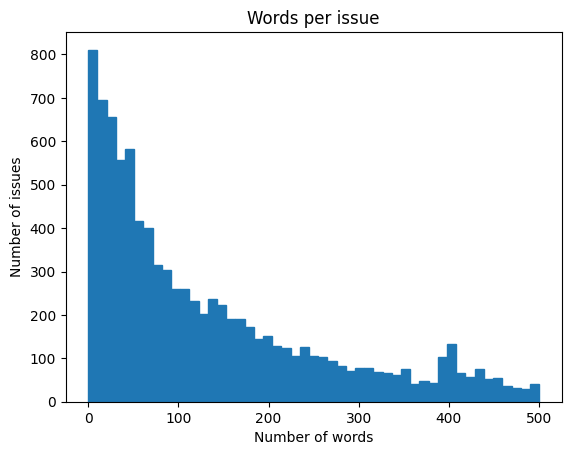

In [ ]:
#looking at word distribution in the texts

import numpy as np
import matplotlib.pyplot as plt

(df_issues["text"].str.split().apply(len).hist(bins=np.linspace(0,500,50), grid=False, edgecolor="C0"))
plt.title("Words per issue")
plt.xlabel("Number of words")
plt.ylabel("Number of issues")
plt.show()

**Creating Training Sets**

In [ ]:
#testing scikit-multilearn

from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
mlb.fit([all_labels])
mlb.transform([["tokenization", "new model"],["pytorch"]])


array([[0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0]])

In [ ]:
! pip install scikit-multilearn

In [ ]:
#using iterative_train_test_split() to create balanced train/test splits

from skmultilearn.model_selection import iterative_train_test_split

def balanced_split(df, test_size=0.5):
  ind = np.expand_dims(np.arange(len(df)), axis=1)
  labels = mlb.transform(df["labels"])
  ind_train, _, ind_test, _ = iterative_train_test_split(ind, labels, test_size)

  return df.iloc[ind_train[:, 0]], df.iloc[ind_test[:, 0]]


In [ ]:
#splitting data into supervised and unsupervised datasets, and then creating balanced training, validation, and test sets for the supervised part

from sklearn.model_selection import train_test_split

df_clean = df_issues[["text", "labels", "split"]].reset_index(drop=True).copy()
df_unsup = df_clean.loc[df_clean["split"] == "unlabeled", ["text", "labels"]]
df_sup = df_clean.loc[df_clean["split"] == "labeled", ["text", "labels"]]

np.random.seed(0)
df_train, df_tmp = balanced_split(df_sup, test_size=0.5)
df_valid, df_test = balanced_split(df_tmp, test_size=0.5)

In [ ]:
! pip install datasets

In [ ]:
#creating DatasetDict with all the splits for downstream tasks

from datasets import Dataset, DatasetDict

ds = DatasetDict({
    "train": Dataset.from_pandas(df_train.reset_index(drop=True)),
    "valid": Dataset.from_pandas(df_valid.reset_index(drop=True)),
    "test": Dataset.from_pandas(df_test.reset_index(drop=True)),
    "unsup": Dataset.from_pandas(df_unsup.reset_index(drop=True))
})

In [ ]:
#Creating Training Slices to evaluate the performance of each classifier as fn of training set size

np.random.seed(0)
all_indices = np.expand_dims(list(range(len(ds["train"]))), axis=1)
indices_pool = all_indices
labels = mlb.transform(ds["train"]["labels"])
train_samples = [8, 16, 32, 64, 128]
train_slices, last_k = [], 0

for i,k in enumerate(train_samples):
  #Split off samples necessary to fill the gap to the next split size
  indices_pool, labels, new_slice, _ = iterative_train_test_split(indices_pool, labels, (k-last_k)/len(labels))
  last_k = k
  if i==0:
    train_slices.append(new_slice)
  else:
    train_slices.append(np.concatenate((train_slices[-1], new_slice)))

#Add full dataset as last slice

train_slices.append(all_indices), train_samples.append(len(ds["train"]))
train_slices = [np.squeeze(train_slice) for train_slice in train_slices]

In [ ]:
print("Target Split sizes:")
print(train_samples)
print("Actual split sizes:")
print([len(x) for x in train_slices])

Target Split sizes:
[8, 16, 32, 64, 128, 223]
Actual split sizes:
[10, 19, 36, 68, 134, 223]


In [ ]:
print(ds["train"][1])

{'text': "Please implement DUMA: Reading Comprehension with Transposition Thinking\n\n# 🚀 Feature request\r\n\r\n<!-- A clear and concise description of the feature proposal.\r\n     Please provide a link to the paper and code in case they exist. -->\r\nThis one is on the race leaderborad top, will you guys consider implement this?\r\n\r\n## Motivation\r\n\r\n<!-- Please outline the motivation for the proposal. Is your feature request\r\n     related to a problem? e.g., I'm always frustrated when [...]. If this is related\r\n     to another GitHub issue, please link here too. -->\r\n\r\n## Your contribution\r\n\r\n<!-- Is there any way that you could help, e.g. by submitting a PR?\r\n     Make sure to read the CONTRIBUTING.MD readme:\r\n     https://github.com/huggingface/transformers/blob/master/CONTRIBUTING.md -->\r\n", 'labels': ['new model']}


**Implementing Naive Bayesline**

In [ ]:
#using multilabel binarizer to create new labels_ids columns in the training sets

def prepare_labels(batch):
  batch["label_ids"] = mlb.transform(batch["labels"])
  return batch

ds = ds.map(prepare_labels, batched=True)

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

In [ ]:
print(ds["train"][1])

{'text': "Please implement DUMA: Reading Comprehension with Transposition Thinking\n\n# 🚀 Feature request\r\n\r\n<!-- A clear and concise description of the feature proposal.\r\n     Please provide a link to the paper and code in case they exist. -->\r\nThis one is on the race leaderborad top, will you guys consider implement this?\r\n\r\n## Motivation\r\n\r\n<!-- Please outline the motivation for the proposal. Is your feature request\r\n     related to a problem? e.g., I'm always frustrated when [...]. If this is related\r\n     to another GitHub issue, please link here too. -->\r\n\r\n## Your contribution\r\n\r\n<!-- Is there any way that you could help, e.g. by submitting a PR?\r\n     Make sure to read the CONTRIBUTING.MD readme:\r\n     https://github.com/huggingface/transformers/blob/master/CONTRIBUTING.md -->\r\n", 'labels': ['new model'], 'label_ids': [0, 0, 0, 1, 0, 0, 0, 0, 0]}


In [ ]:
#using micro(tracks performance on frequent labels) and macro(tracks perf on all labels disregard of freq) F1-scores

from collections import defaultdict

macro_scores, micro_scores = defaultdict(list), defaultdict(list)

In [ ]:
#training baseline model and evalute the classifier across increasing training set sizes

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.feature_extraction.text import CountVectorizer

for train_slice in train_slices:
  #Get training slice and test data
  ds_train_sample = ds["train"].select(train_slice)
  y_train = np.array(ds_train_sample["label_ids"])
  y_test = np.array(ds["test"]["label_ids"])
  #Use a simple count vectorizer to encode our text as token counts
  count_vect = CountVectorizer()
  X_train_counts = count_vect.fit_transform(ds_train_sample["text"])
  X_test_counts = count_vect.transform(ds["test"]["text"])
  #Create and train our model!
  classifier = BinaryRelevance(classifier=MultinomialNB())
  classifier.fit(X_train_counts, y_train)
  #Generate predictions and evaluate
  y_pred_test = classifier.predict(X_test_counts)
  clf_report = classification_report(y_test, y_pred_test, target_names=mlb.classes_,
                                     zero_division=0, output_dict=True)
  #Store metrics
  macro_scores["Naive Bayes"].append(clf_report["macro avg"]["f1-score"])
  micro_scores["Naive Bayes"].append(clf_report["micro avg"]["f1-score"])


<Figure size 640x480 with 0 Axes>

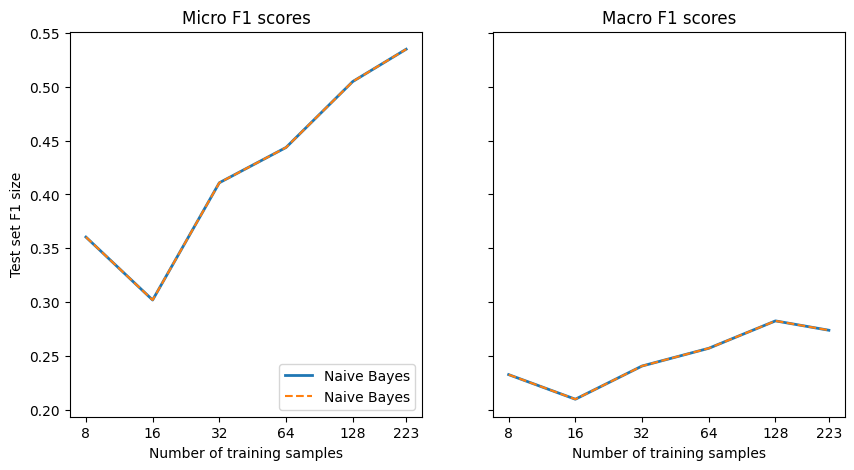

In [ ]:
#helper function to plot the results

import matplotlib.pyplot as plt

def plot_metrics(micro_scores, macro_scores, sample_sizes, current_model):
  fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,5), sharey=True)

  for run in micro_scores:
    ax0.plot(sample_sizes, micro_scores[run], label=run, linewidth=2)
    ax1.plot(sample_sizes, macro_scores[run], label=run, linewidth=2)

  else:
    ax0.plot(sample_sizes, micro_scores[run], label=run, linestyle="dashed")
    ax1.plot(sample_sizes, macro_scores[run], label=run, linestyle="dashed")

  ax0.set_title("Micro F1 scores")
  ax1.set_title("Macro F1 scores")
  ax0.set_ylabel("Test set F1 size")
  ax0.legend(loc="lower right")

  for ax in [ax0, ax1]:
    ax.set_xlabel("Number of training samples")
    ax.set_xscale("log")
    ax.set_xticks(sample_sizes)
    ax.set_xticklabels(sample_sizes)
    ax.minorticks_off()

plt.tight_layout()
plt.show()
plot_metrics(micro_scores, macro_scores, train_samples, "Naive Bayes")

**Working with No Labeled Data**

In [ ]:
#loading BERT-base in the fill-mask pipeline

from transformers import pipeline

pipe = pipeline("fill-mask", model="bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if

In [ ]:
#constructing a movie description, and adding a prompt to it with a masked word

movie_desc = "The main characters of the movie madacascar \
are lion, a zebra, a giraffe, and a hippo."

prompt = "The movie is about [MASK]."

output = pipe(movie_desc + prompt)

for element in output:
  print(f"Token {element['token_str']}:\t {element['score']:.3f}%")

Token lions:	 0.154%
Token animals:	 0.113%
Token birds:	 0.027%
Token lion:	 0.022%
Token tigers:	 0.015%


In [ ]:
#querying the pipeline for the probability of a few given tokens

output = pipe(movie_desc + prompt, targets=["animals", "cars"])

for element in output:
  print(f"Token {element['token_str']}:\t{element['score']:.3f}%")

Token animals:	0.113%
Token cars:	0.000%


In [ ]:
#initializing MNLI model for zero-shot classification

from transformers import pipeline

pipe = pipeline("zero-shot-classification", device=0)

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
sample = ds["train"][0]
print(sample)

{'text': "Add new CANINE model\n\n# 🌟 New model addition\r\n\r\n## Model description\r\n\r\nGoogle recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:\r\n\r\n> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokenization step. While recent tokenization approaches based on data-derived subword lexicons are less brittle than manually engineered tokenizers, these techniques are not equally suited to all languages, and the use of any fixed vocabulary may limit a model's ability to adapt. In this paper, we present CANINE, a neural encoder that operates directly on character sequences, without explicit tokenization or vocabulary, and a pre-training strategy that operates either directly on characters or optionally uses subwords as a soft inductive bias. To use its finer-grained input e

In [ ]:
#passing texts to the pipeline along with the label names

sample = ds["train"][0]
print(f"Labels: {sample['labels']}")
output = pipe(sample["text"], all_labels, multi_label=True)
print(output["sequence"][:400])
print("\nPredictions:")

for label, score in zip(output["labels"], output["scores"]):
  print(f"{label}, {score:.2f}")

Labels: ['new model']
Add new CANINE model

# 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokeni

Predictions:
new model, 0.98
tensorflow or tf, 0.37
examples, 0.34
usage, 0.30
pytorch, 0.25
documentation, 0.25
model training, 0.24
tokenization, 0.17
pipeline, 0.16


In [ ]:
#writing a fn that feeds a single example through the zero-shot pipeline, and then scale it out to the whole validation set by map()

def zero_shot_pipeline(example):
  output = pipe(example["text"], all_labels, multi_label=True)
  example["predicted_labels"] = output["labels"]
  example["scores"] = output["scores"]
  return example

ds_zero_shot = ds["valid"].map(zero_shot_pipeline)

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1123: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [ ]:
# function to determine wheather a threshold or k highest method is better

def get_preds(example, threshold=None, topk=None):
  preds = []
  if threshold:
    for label, score in zip(example["predicted_labels"], example["scores"]):
      if score >= threshold:
        preds.append(label)
  elif topk:
    for i in range(topk):
      preds.append(example["predicted_labels"][i])

  else:
    raise ValueError("Set either 'threshold' or 'topk'.")

  return {"pred_label_ids": list(np.squeeze(mlb.transform([preds])))}

In [ ]:
#functin that returns the scikit-learn classification report from a dataset with the predicted labels
def get_clf_report(ds):
  y_true = np.array(ds["label_ids"])
  y_pred = np.array(ds["pred_label_ids"])
  return classification_report(y_true, y_pred, target_names=mlb.classes_, zero_division=0,
                               output_dict=True)

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

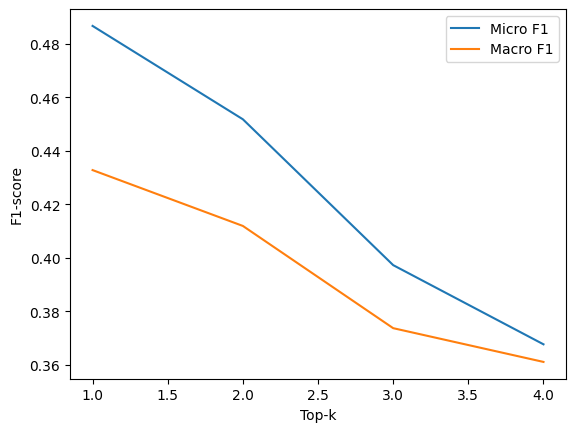

In [ ]:
#looking at top-k methods, increasing k for several values and plotting the micro and macro F1-scores across the validation set

macros, micros = [], []
topks = [1,2,3,4]
for topk in topks:
  ds_zero_shot = ds_zero_shot.map(get_preds, batched=False, fn_kwargs={'topk':topk})

  clf_report = get_clf_report(ds_zero_shot)
  micros.append(clf_report["micro avg"]["f1-score"])
  macros.append(clf_report["macro avg"]["f1-score"])

plt.plot(topks, micros, label="Micro F1")
plt.plot(topks, macros, label="Macro F1")
plt.xlabel("Top-k")
plt.ylabel("F1-score")
plt.legend(loc='best')
plt.show()

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

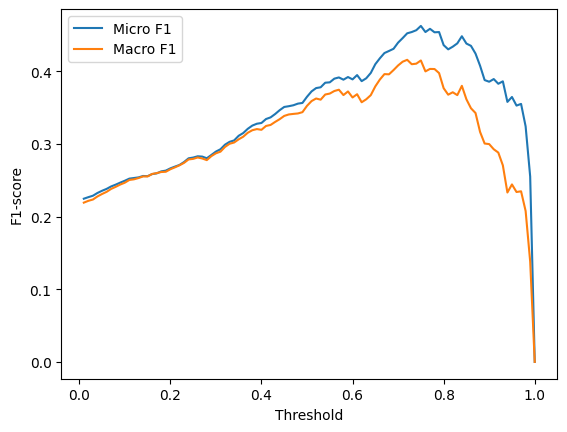

In [ ]:
#for threshold

macros, micros = [], []
thresholds = np.linspace(0.01, 1, 100)
for threshold in thresholds:
  ds_zero_shot = ds_zero_shot.map(get_preds, fn_kwargs={"threshold": threshold})
  clf_report = get_clf_report(ds_zero_shot)
  micros.append(clf_report["micro avg"]["f1-score"])
  macros.append(clf_report["macro avg"]["f1-score"])

plt.plot(thresholds, micros, label="Micro F1")
plt.plot(thresholds, macros, label="Macro F1")
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.legend(loc="best")
plt.show()

In [ ]:
best_t, best_micro = thresholds[np.argmax(micros)], np.max(micros)
print(f"Best threshold (micro): {best_t} with F1-score {best_micro:.2f}.")
bext_t, best_macro = thresholds[np.argmax(macros)], np.max(macros)
print(f"Best threshold (macro): {bext_t} with F1-score {best_macro:.2f}.")

Best threshold (micro): 0.75 with F1-score 0.46.
Best threshold (macro): 0.72 with F1-score 0.42.


Map:   0%|          | 0/111 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1123: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Map:   0%|          | 0/111 [00:00<?, ? examples/s]

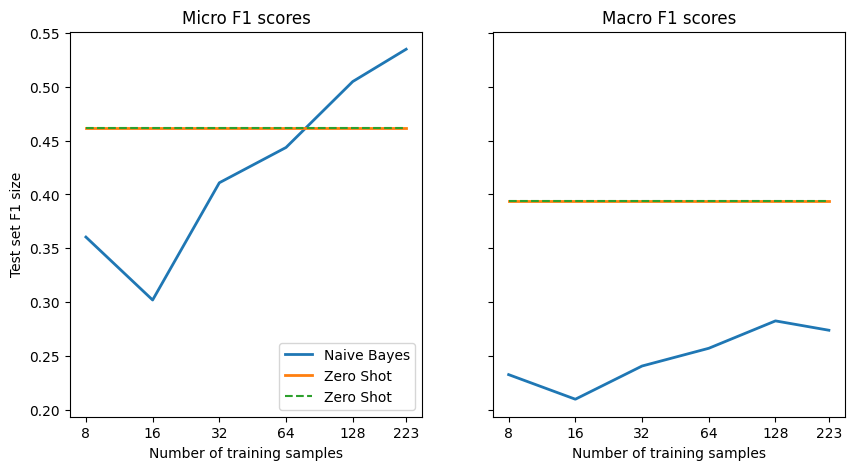

In [ ]:
#comparing top-1 zero-shot classification against Naive Bayes on the test set

ds_zero_shot = ds['test'].map(zero_shot_pipeline)
ds_zero_shot = ds_zero_shot.map(get_preds, fn_kwargs={'topk': 1})
clf_report = get_clf_report(ds_zero_shot)
for train_slice in train_slices:
  macro_scores["Zero Shot"].append(clf_report["macro avg"]["f1-score"])
  micro_scores["Zero Shot"].append(clf_report["micro avg"]["f1-score"])

plot_metrics(micro_scores, macro_scores, train_samples, "zero Shot")

**Few Labels example**

In [ ]:
! pip install nlpaug

In [ ]:
! pip install sacremoses

In [ ]:
from transformers import set_seed
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

set_seed(3)
text = "Even if you defeat me Megatron, others will rise to defeat your tyranny"
augs = {}
augs["synonym_replace"] = naw.SynonymAug(aug_src='wordnet')
augs["random_insert"] = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased",
                                device="cpu", action="insert", aug_max=1)
augs["random_swap"] = naw.RandomWordAug(action="swap")
augs["random_delete"] = naw.RandomWordAug()
augs["bt_en_de"] = naw.BackTranslationAug(
    from_model_name='facebook/wmt19-en-de',
    to_model_name='facebook/wmt19-de-en'
)
for k,v in augs.items():
    print(f"Original text: {text}")
    print(f"{k}: {v.augment(text)}")
    print("")

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of FSMTForConditionalGeneration were not initialized from the model checkpoint at facebook/wmt19-en-de and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it f

Original text: Even if you defeat me Megatron, others will rise to defeat your tyranny
synonym_replace: ['Even if you vote down me Megatron, others will turn out to defeat your tyranny']

Original text: Even if you defeat me Megatron, others will rise to defeat your tyranny
random_insert: ['even if you defeat me megatron, others will rise to simply defeat your tyranny']

Original text: Even if you defeat me Megatron, others will rise to defeat your tyranny
random_swap: ['Even if you defeat Megatron me, others to will rise defeat your tyranny']

Original text: Even if you defeat me Megatron, others will rise to defeat your tyranny
random_delete: ['Even if me Megatron, will rise to tyranny']

Original text: Even if you defeat me Megatron, others will rise to defeat your tyranny
bt_en_de: ['Even if you defeat me, others will rise up to defeat your tyranny']



In [ ]:
#Data Augmentation by using synonym replacement
#using ContextualWordEmbsAug from NlpAug

from transformers import set_seed
import nlpaug.augmenter.word as naw

set_seed(3)
aug = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased", device="cpu", action="substitute")

text = "Transformers are the most popular toys"
print(f"Original text: {text}")
print(f"Augmented text: {aug.augment(text)}")

Original text: Transformers are the most popular toys
Augmented text: ['transformers — the most coveted toys']


In [ ]:
def augment_text(batch, transformations_per_example=1):
    text_aug, label_ids = [], []
    for text, labels in zip(batch["text"], batch["label_ids"]):
        text_aug += [text]
        label_ids += [labels]
        for _ in range(transformations_per_example):
            text_aug += [aug.augment(text)]
            label_ids += [labels]
    return {"text": text_aug, "label_ids": label_ids}

In [ ]:
# #will come back to it later
# for train_slice in train_slices:
#     # Get training slice and test data
#     ds_train_sample = ds["train"].select(train_slice)
#     # Flatten augmentations and align labels!
#     ds_train_aug = ds_train_sample.map(
#         augment_text, batched=True, remove_columns=ds_train_sample.column_names).shuffle(seed=42)
#     y_train = np.array(ds_train_aug["label_ids"])
#     y_test = np.array(ds["test"]["label_ids"])
#     # Use a simple count vectorizer to encode our texts as token counts
#     count_vect = CountVectorizer()
#     X_train_counts = count_vect.fit_transform(ds_train_aug["text"])
#     X_test_counts = count_vect.transform(ds["test"]["text"])
#     # Create and train our model!
#     classifier = BinaryRelevance(classifier=MultinomialNB())
#     classifier.fit(X_train_counts, y_train)
#     # Generate predictions and evaluate
#     y_pred_test = classifier.predict(X_test_counts)
#     clf_report = classification_report(
#         y_test, y_pred_test, target_names=mlb.classes_, zero_division=0,
#         output_dict=True)
#     # Store metrics
#     macro_scores["Naive Bayes + Aug"].append(clf_report["macro avg"]["f1-score"])
#     micro_scores["Naive Bayes + Aug"].append(clf_report["micro avg"]["f1-score"])

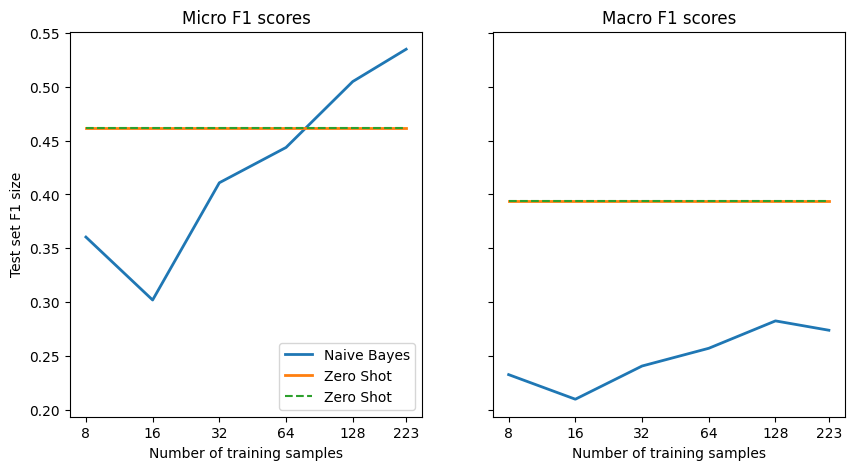

In [ ]:
#plotting the results

plot_metrics(micro_scores, macro_scores, train_samples, "Naive Bayes + Aug")

**Using Embeddings as a Lookup Table**

In [ ]:
#using GPT-2 and pooling methods to get single embedding vector for the whole sentence

import torch
from transformers import AutoTokenizer, AutoModel

model_ckpt = "miguelvictor/python-gpt2-large"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

def mean_pooling(model_output, attention_mask):
  #Extract the token embeddings
  token_embeddings = model_output[0]
  #compute the attention mask
  input_mask_expanded = (attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float())
  #Sum the embeddings, but ignore masked tokens
  sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
  sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
  #Return the average as a single vector
  return sum_embeddings / sum_mask

def embed_text(examples):
  inputs = tokenizer(examples["text"], padding=True, truncation=True, max_length=128, return_tensors="pt")
  with torch.no_grad():
    model_output = model(**inputs)
  pooled_embeds = mean_pooling(model_output, inputs["attention_mask"])
  return {"embeddings": pooled_embeds.cpu().numpy()}

In [ ]:
#GPT-style models don't have a padding token, and therefore padding is needed to be added one before getting embeddings in a batched fashion

tokenizer.pad_token = tokenizer.eos_token
embs_train = ds["train"].map(embed_text, batched=True, batch_size=16)
embs_valid = ds["valid"].map(embed_text, batched=True, batch_size=16)
embs_test = ds["test"].map(embed_text, batched=True, batch_size=16)


Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

In [ ]:
#!pip install faiss-gpu

In [ ]:
#Using FAISS index from Dataset
import faiss
embs_train.add_faiss_index(column='embeddings')

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['text', 'labels', 'label_ids', 'embeddings'],
    num_rows: 223
})

In [ ]:
#performing nearest neighbor lookup with get_nearest_examples()

i, k = 0, 3 #Select the first query and 3 nearest neighbors
rn, nl = "\r\n\r\n", "\n" #Used to remove newlines in text for compact display

query = np.array(embs_valid[i]["embeddings"], dtype=np.float32)
scores, samples = embs_train.get_nearest_examples("embeddings", query, k=k)

print(f"Query Labels: {embs_valid[i]['labels']}")
print(f"Query Text: \n{embs_valid[i]['text'][:200].replace(rn,nl)}[...]\n")
print("="*50)
print(f"Retrieved documents:")
for score, label, text in zip(scores, samples["labels"], samples["text"]):
  print("="*50)
  print(f"TEXT:\n{text[:200].replace(rn, nl)}[...]")
  print(f"Score:{score:.2f}")
  print(f"Labels: {label}")

Query Labels: ['new model']
Query Text: 
Implementing efficient self attention in T5

# 🌟 New model addition
My teammates and I (including @ice-americano) would like to use efficient self attention methods such as Linformer, Performer and[...]

Retrieved documents:
TEXT:
Add Linformer model

# 🌟 New model addition
## Model description
### Linformer: Self-Attention with Linear Complexity
Paper published June 9th on ArXiv: https://arxiv.org/abs/2006.04768
La[...]
Score:54.92
Labels: ['new model']
TEXT:
Add FAVOR+ / Performer attention

# 🌟 FAVOR+ / Performer attention addition
Are there any plans to add this new attention approximation block to Transformers library?
## Model description
The n[...]
Score:57.90
Labels: ['new model']
TEXT:
Implement DeLighT: Very Deep and Light-weight Transformers

# 🌟 New model addition
## Model description
DeLight, that delivers similar or better performance than transformer-based models with sign[...]
Score:60.12
Labels: ['new model']


In [ ]:
#investigating value of k and number of label assignents

def get_sample_preds(sample, m):
  return (np.sum(sample["label_ids"], axis=0) >=m).astype(int)

def find_best_k_m(ds_train, valid_queries, valid_labels, max_k=17):
  max_k = min(len(ds_train), max_k)
  perf_micro = np.zeros((max_k, max_k))
  perf_macro = np.zeros((max_k, max_k))
  for k in range(1, max_k):
    for m in range(1, k+1):
      _, samples = ds_train.get_nearest_examples_batch("embeddings", valid_queries, k=k)
      y_pred = np.array([get_sample_preds(s,m) for s in samples])
      clf_report = classification_report(valid_labels, y_pred,
                                         target_names=mlb.classes_, zero_division=0,
                                         output_dict=True)
      perf_micro[k, m] = clf_report["micro avg"]["f1-score"]
      perf_macro[k, m] = clf_report["macro avg"]["f1-score"]
  return perf_micro, perf_macro

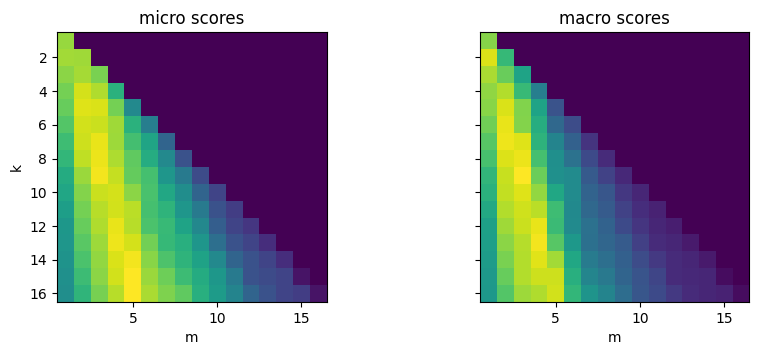

In [ ]:
#checking the best values with all the training samples and visualize the socres for all k and m

valid_labels = np.array(embs_valid["label_ids"])
valid_queries = np.array(embs_valid["embeddings"], dtype=np.float32)
perf_micro, perf_macro = find_best_k_m(embs_train, valid_queries, valid_labels)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
ax0.imshow(perf_micro)
ax1.imshow(perf_macro)

ax0.set_title("micro scores")
ax0.set_ylabel("k")
ax1.set_title("macro scores")
for ax in [ax0, ax1]:
  ax.set_xlim([0.5, 17 - 0.5])
  ax.set_ylim([17 - 0.5, 0.5])
  ax.set_xlabel("m")

plt.show()

In [ ]:
#finding the optimal k and m

k, m = np.unravel_index(perf_micro.argmax(), perf_micro.shape)
print(f"Best k: {k}, best m: {m}")

Best k: 15, best m: 5


In [ ]:
print(embs_train)

Dataset({
    features: ['text', 'labels', 'label_ids', 'embeddings'],
    num_rows: 223
})


In [ ]:
embs_train.drop_index("embeddings")

In [ ]:
# #removing embeddings
# embs_train.remove_columns('embeddings')

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

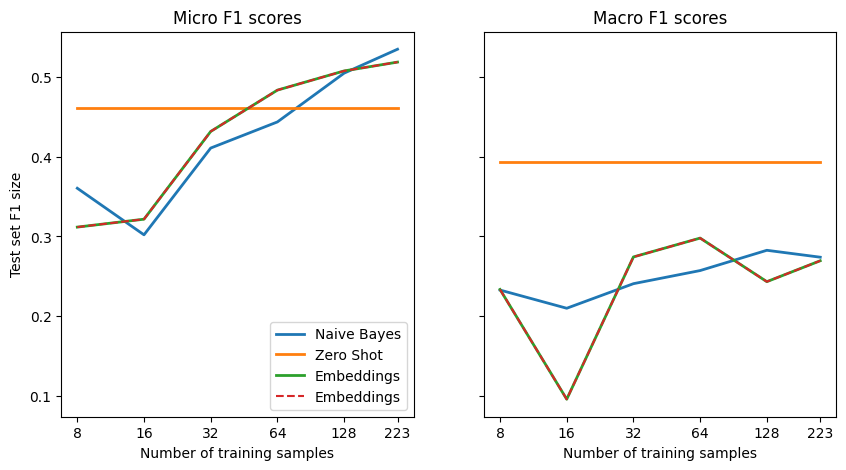

In [ ]:
#going through the slices of the training set and evaluate the performance
test_labels = np.array(embs_test["label_ids"])
test_queries = np.array(embs_test["embeddings"], dtype=np.float32)

for train_slice in train_slices:
  #Create a Faiss index from training slice
  embs_train_tmp = embs_train.select(train_slice)
  embs_train_tmp.add_faiss_index("embeddings")
  #Get best k, m values with validation set
  perf_micro, _= find_best_k_m(embs_train_tmp, valid_queries, valid_labels)
  k, m = np.unravel_index(perf_micro.argmax(), perf_micro.shape)
  #Get predictions on test set
  _, samples = embs_train_tmp.get_nearest_examples_batch("embeddings", test_queries, k=int(k))
  y_pred = np.array([get_sample_preds(s, m) for s in samples])
  #Evaluate predictions
  clf_report = classification_report(test_labels, y_pred,
                                     target_names=mlb.classes_, zero_division=0,
                                     output_dict=True,)
  macro_scores["Embeddings"].append(clf_report["macro avg"]["f1-score"])
  micro_scores["Embeddings"].append(clf_report["micro avg"]["f1-score"])

plot_metrics(micro_scores, macro_scores, train_samples, "Embeddings")

**Fine-Tuning a Vanilla Transformer**

In [ ]:
# !pip uninstall accelerate
# !pip uninstall transformers
# !pip install git+https://github.com/huggingface/accelerate
# !pip install --upgrade transformers

In [ ]:
# !pip uninstall transformers
# !pip install transformers

In [ ]:
#using standard BERT as a starting point

import torch
from transformers import (AutoTokenizer, AutoConfig, AutoModelForSequenceClassification)

model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize(batch):
  return tokenizer(batch["text"], truncation=True, max_length=128)

ds_enc = ds.map(tokenize, batched=True)
ds_enc = ds_enc.remove_columns(['labels', 'text'])

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

In [ ]:
#type label_ids to float
ds_enc.set_format("torch")
ds_enc = ds_enc.map(lambda x: {'label_ids_f': x['label_ids'].to(torch.float)}, remove_columns=['label_ids'])
ds_enc = ds_enc.rename_column('label_ids_f', 'label_ids')

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

In [ ]:
#avoid overfitting, setting load_best_model_at_end=True and choose the best model based on the micro F1-score

from transformers import Trainer, TrainingArguments



In [ ]:
training_args_fine_tune = TrainingArguments(
    output_dir="./results", num_train_epochs=20, learning_rate=2e-5,
    lr_scheduler_type="constant", per_device_train_batch_size=4,
    per_device_eval_batch_size=32, weight_decay=0.0, evaluation_strategy="epoch",
    save_strategy="epoch", logging_strategy="epoch", load_best_model_at_end=True,
    metric_for_best_model="micro f1", save_total_limit=1, log_level='error')

In [ ]:
#making sure F1 score is calculated during the evaluation

from scipy.special import expit as sigmoid

def compute_metrics(pred):
  y_true = pred.label_ids
  y_pred = sigmoid(pred.predictions)
  y_pred = (y_pred>0.5).astype(float)

  clf_dict = classification_report(y_true, y_pred, target_names=all_labels,
                                   zero_division=0, output_dict=True)
  return {"micro f1": clf_dict["micro avg"]["f1-score"],
          "macro f1": clf_dict["macro avg"]["f1-score"]}

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
#for each training set slice, training a classifier from scratch, load the best model at the end of the training loop and store the results on the test set

config = AutoConfig.from_pretrained(model_ckpt)
config.num_labels = len(all_labels)
config.problem_type = "multi_label_classification"

for train_slice in train_slices:
  model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config)
  trainer = Trainer(model=model,
                    tokenizer=tokenizer,
                    args=training_args_fine_tune,
                    compute_metrics=compute_metrics,
                    train_dataset=ds_enc["train"].select(train_slice),
                    eval_dataset=ds_enc["valid"],)
  trainer.train()
  pred = trainer.predict(ds_enc["test"])
  metrics = compute_metrics(pred)
  macro_scores["Fine-tune (vanilla)"].append(metrics["macro f1"])
  micro_scores["Fine-tune (vanilla)"].append(metrics["micro f1"])



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.654400,0.613982,0.212500,0.072948
2,0.608400,0.581535,0.029851,0.012698
3,0.553500,0.545168,0.016000,0.007168
4,0.523700,0.507453,0.016000,0.006944
5,0.486700,0.478053,0.016129,0.007168
6,0.455800,0.454338,0.000000,0.000000
7,0.434100,0.437341,0.000000,0.000000
8,0.410800,0.423018,0.000000,0.000000
9,0.385800,0.413294,0.000000,0.000000
10,0.373100,0.406566,0.000000,0.000000


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.699900,0.635486,0.115108,0.067010
2,0.619000,0.591825,0.095652,0.047173
3,0.566200,0.543854,0.097345,0.032565
4,0.511800,0.495360,0.016393,0.013072
5,0.472500,0.462073,0.016393,0.013072
6,0.434500,0.437833,0.016393,0.013072
7,0.406500,0.421227,0.016529,0.013072
8,0.389800,0.405844,0.016529,0.013072
9,0.369000,0.390212,0.016529,0.013072
10,0.358700,0.381065,0.016529,0.013072


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.648300,0.601002,0.110638,0.068032
2,0.553100,0.507059,0.016393,0.013072
3,0.471800,0.457873,0.016393,0.013072
4,0.421300,0.413114,0.016393,0.013072
5,0.385500,0.387258,0.016529,0.013072
6,0.354400,0.374826,0.000000,0.000000
7,0.333100,0.364431,0.000000,0.000000
8,0.326000,0.364528,0.000000,0.000000
9,0.308200,0.357484,0.000000,0.000000
10,0.298300,0.354017,0.000000,0.000000


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.617900,0.547813,0.032258,0.021961
2,0.476500,0.425731,0.016529,0.013072
3,0.390300,0.383192,0.016529,0.013072
4,0.358900,0.370427,0.000000,0.000000
5,0.340700,0.355737,0.000000,0.000000
6,0.323300,0.350877,0.016529,0.013072
7,0.314100,0.346078,0.016529,0.013072
8,0.294300,0.336522,0.064516,0.032420
9,0.274100,0.327192,0.153846,0.067888
10,0.253800,0.313591,0.244604,0.108206


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.544000,0.422143,0.016393,0.013072
2,0.382300,0.365715,0.000000,0.000000
3,0.348500,0.352576,0.000000,0.000000
4,0.326200,0.335635,0.032787,0.021008
5,0.307400,0.317706,0.297872,0.135473
6,0.278100,0.298384,0.435897,0.183362
7,0.244600,0.289604,0.487805,0.197653
8,0.215000,0.277046,0.484848,0.226694
9,0.186500,0.248906,0.530120,0.281242
10,0.165200,0.248914,0.531792,0.276235


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.480300,0.372819,0.000000,0.000000
2,0.356100,0.345805,0.000000,0.000000
3,0.322100,0.311288,0.235294,0.093407
4,0.283200,0.281394,0.443038,0.172313
5,0.248100,0.259377,0.506024,0.244665
6,0.208800,0.238243,0.611111,0.328728
7,0.178200,0.225596,0.592179,0.321684
8,0.149800,0.216503,0.600000,0.324688
9,0.128500,0.201338,0.663043,0.503939
10,0.110200,0.195264,0.687500,0.533449


In [ ]:
def plot_metrics(micro_scores, macro_scores, sample_sizes, current_model):
  fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,5), sharey=True)

  for run in micro_scores:
    ax0.plot(sample_sizes, micro_scores[run], label=run, linewidth=2)
    ax1.plot(sample_sizes, macro_scores[run], label=run, linewidth=2)

  else:
    ax0.plot(sample_sizes, micro_scores[run], label=run, linestyle="dashed")
    ax1.plot(sample_sizes, macro_scores[run], label=run, linestyle="dashed")

  ax0.set_title("Micro F1 scores")
  ax1.set_title("Macro F1 scores")
  ax0.set_ylabel("Test set F1 size")
  ax0.legend(loc="lower right")

  for ax in [ax0, ax1]:
    ax.set_xlabel("Number of training samples")
    ax.set_xscale("log")
    ax.set_xticks(sample_sizes)
    ax.set_xticklabels(sample_sizes)
    ax.minorticks_off()

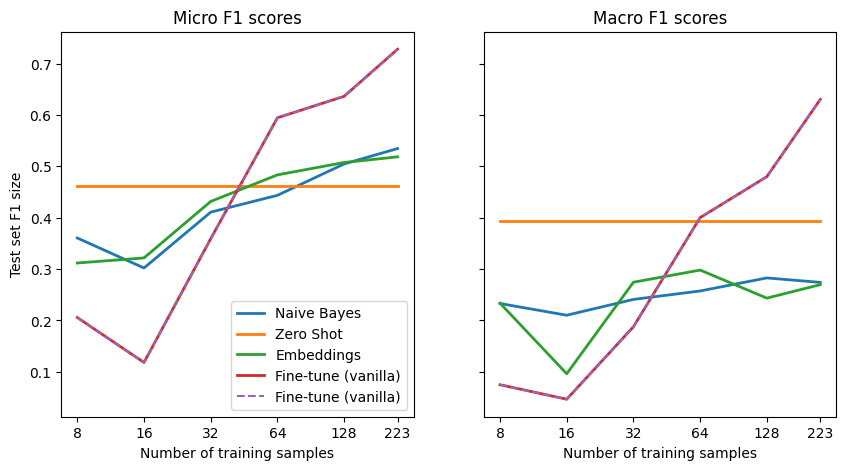

In [ ]:
plot_metrics(micro_scores, macro_scores, train_samples, "Fine-tune (vanilla)")

**Leveraging Unlabeled Data**

In [ ]:
#fine-tuning BERT model with masked language modeling on the unlabeled protion of the dataset
#need extra step when tokenizing data and a special data collator

def tokenize(batch):
  return tokenizer(batch["text"], truncation=True, max_length=128, return_special_tokens_mask=True)

ds_mlm = ds.map(tokenize, batched=True)
ds_mlm = ds_mlm.remove_columns(["labels", "text", "label_ids"])

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

In [ ]:
# implementing DataCollatorForLanguageModeling

from transformers import DataCollatorForLanguageModeling, AUDIO_SPECTROGRAM_TRANSFORMER_PRETRAINED_CONFIG_ARCHIVE_MAP

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

In [ ]:
#quick look at the working of data collator
from transformers import set_seed
set_seed(3)
data_collator.return_tensors = "np"
inputs = tokenizer("Transformers are awesome!", return_tensors="np")
outputs = data_collator([{"input_ids": inputs["input_ids"][0]}])

original_input_ids = inputs["input_ids"][0]
masked_input_ids = outputs["input_ids"][0]

pd.DataFrame({
    "Original tokens": tokenizer.convert_ids_to_tokens(inputs["input_ids"][0]),
    "Masked tokens": tokenizer.convert_ids_to_tokens(outputs["input_ids"][0]),
    "Original input_ids": original_input_ids,
    "Masked input_ids": masked_input_ids,
    "Labels": outputs["labels"][0]}).T

,0,1,2,3,4,5
Original tokens,[CLS],transformers,are,awesome,!,[SEP]
Masked tokens,[CLS],transformers,are,awesome,[MASK],[SEP]
Original input_ids,101,19081,2024,12476,999,102
Masked input_ids,101,19081,2024,12476,103,102
Labels,-100,-100,-100,-100,999,-100


In [ ]:
# switching dtype "np" to "pt"

data_collator.return_tensors = "pt"

In [ ]:
#login detail
from google.colab import userdata
key=userdata.get('huggingface')

from huggingface_hub import login
login(token=key, write_permission=True )

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
#setting up the TrainingArguments and Trainer for fine-tuning

from transformers import AutoModelForMaskedLM

training_args = TrainingArguments(
    output_dir = f"{model_ckpt}-issues-128", per_device_train_batch_size=32,
    logging_strategy="epoch", evaluation_strategy="epoch",
    save_strategy="no", num_train_epochs=16, push_to_hub=True, log_level="error",
    report_to="none")

trainer = Trainer(
    model=AutoModelForMaskedLM.from_pretrained("bert-base-uncased"),
    tokenizer=tokenizer, args=training_args, data_collator=data_collator,
    train_dataset=ds_mlm["unsup"], eval_dataset=ds_mlm["train"]
)

trainer.train()
trainer.push_to_hub("Training complete!")

{'loss': 2.1115, 'learning_rate': 4.6875e-05, 'epoch': 1.0}
{'eval_loss': 1.6929855346679688, 'eval_runtime': 2.1453, 'eval_samples_per_second': 103.947, 'eval_steps_per_second': 13.052, 'epoch': 1.0}
{'loss': 1.6354, 'learning_rate': 4.375e-05, 'epoch': 2.0}
{'eval_loss': 1.367012619972229, 'eval_runtime': 2.1485, 'eval_samples_per_second': 103.795, 'eval_steps_per_second': 13.033, 'epoch': 2.0}
{'loss': 1.4808, 'learning_rate': 4.0625000000000005e-05, 'epoch': 3.0}
{'eval_loss': 1.4257400035858154, 'eval_runtime': 2.1448, 'eval_samples_per_second': 103.974, 'eval_steps_per_second': 13.055, 'epoch': 3.0}
{'loss': 1.393, 'learning_rate': 3.7500000000000003e-05, 'epoch': 4.0}
{'eval_loss': 1.4305278062820435, 'eval_runtime': 2.1355, 'eval_samples_per_second': 104.427, 'eval_steps_per_second': 13.112, 'epoch': 4.0}
{'loss': 1.3415, 'learning_rate': 3.4375e-05, 'epoch': 5.0}
{'eval_loss': 1.2622349262237549, 'eval_runtime': 2.0985, 'eval_samples_per_second': 106.264, 'eval_steps_per_secon

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.73k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/hndc/bert-base-uncased-issues-128/commit/e60642c2decb00ca81f0f650219993f7110ad095', commit_message='Training complete!', commit_description='', oid='e60642c2decb00ca81f0f650219993f7110ad095', pr_url=None, pr_revision=None, pr_num=None)

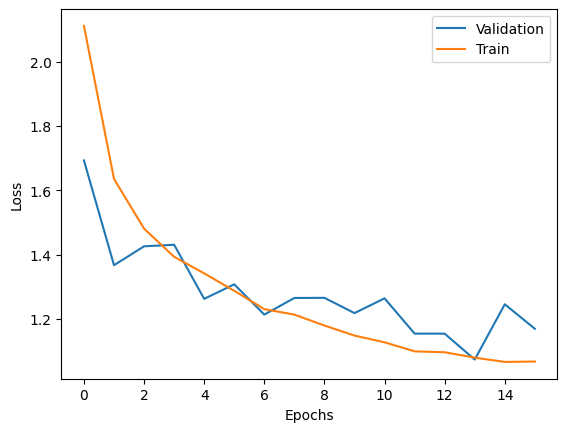

In [ ]:
#trainer's log history to took at the training and validation losses of the model

df_log = pd.DataFrame(trainer.state.log_history)

(df_log.dropna(subset=["eval_loss"]).reset_index()["eval_loss"].plot(label="Validation"))
df_log.dropna(subset=["loss"]).reset_index()["loss"].plot(label="Train")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()

**Fine-Tuning a classifier**

In [ ]:
#repeating the fine-tuning procedure with the slight difference that we load the custom checkpoint

model_ckpt = "hndc/bert-base-uncased-issues-128"
config = AutoConfig.from_pretrained(model_ckpt)
config.num_labels = len(all_labels)
config.problem_type = "multi_label_classification"

for train_slice in train_slices:
  model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config)

  trainer = Trainer(
      model=model,
      tokenizer=tokenizer,
      args=training_args_fine_tune,
      compute_metrics=compute_metrics,
      train_dataset=ds_enc["train"].select(train_slice),
      eval_dataset=ds_enc["valid"])

  trainer.train()
  pred = trainer.predict(ds_enc['test'])
  metrics = compute_metrics(pred)
  #DA refers to domian adaptation
  macro_scores['Fine-tune (DA)'].append(metrics['macro f1'])
  micro_scores['Fine-tune (DA)'].append(metrics['micro f1'])

config.json:   0%|          | 0.00/664 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at hndc/bert-base-uncased-issues-128 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.662900,0.601904,0.060150,0.037378
2,0.549700,0.532004,0.000000,0.000000
3,0.479300,0.482748,0.000000,0.000000
4,0.432500,0.447531,0.000000,0.000000
5,0.396800,0.423857,0.000000,0.000000
6,0.374700,0.408107,0.000000,0.000000
7,0.349000,0.397080,0.000000,0.000000
8,0.330700,0.388844,0.000000,0.000000
9,0.313700,0.383245,0.000000,0.000000
10,0.303800,0.378190,0.000000,0.000000


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at hndc/bert-base-uncased-issues-128 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.646900,0.566174,0.030769,0.023392
2,0.498800,0.472783,0.000000,0.000000
3,0.422500,0.421777,0.000000,0.000000
4,0.379600,0.395162,0.000000,0.000000
5,0.354700,0.380065,0.000000,0.000000
6,0.325200,0.369934,0.000000,0.000000
7,0.308900,0.363459,0.000000,0.000000
8,0.294200,0.358946,0.000000,0.000000
9,0.267800,0.354696,0.016529,0.022222
10,0.255500,0.349036,0.016529,0.022222


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at hndc/bert-base-uncased-issues-128 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.598800,0.485963,0.000000,0.000000
2,0.429300,0.402519,0.000000,0.000000
3,0.365400,0.375511,0.000000,0.000000
4,0.335700,0.358785,0.000000,0.000000
5,0.311500,0.348236,0.000000,0.000000
6,0.288400,0.339871,0.000000,0.000000
7,0.265800,0.328842,0.208955,0.092063
8,0.245300,0.322875,0.285714,0.138816
9,0.223600,0.317011,0.303448,0.139632
10,0.206900,0.313820,0.309859,0.149845


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at hndc/bert-base-uncased-issues-128 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.536300,0.410197,0.000000,0.000000
2,0.374100,0.362519,0.000000,0.000000
3,0.337300,0.346978,0.000000,0.000000
4,0.313700,0.326664,0.152672,0.063492
5,0.284500,0.311697,0.328767,0.133607
6,0.255000,0.296984,0.386667,0.177611
7,0.222500,0.283691,0.458599,0.218034
8,0.193400,0.269386,0.481481,0.223101
9,0.168100,0.257735,0.493827,0.259259
10,0.150600,0.251568,0.509091,0.262963


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at hndc/bert-base-uncased-issues-128 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.459000,0.364276,0.000000,0.000000
2,0.342400,0.329996,0.016529,0.008889
3,0.302900,0.304709,0.307692,0.114091
4,0.261300,0.270324,0.487805,0.187155
5,0.221800,0.245675,0.529412,0.230120
6,0.187200,0.226632,0.566474,0.311473
7,0.156300,0.211048,0.590909,0.336164
8,0.130100,0.196229,0.634409,0.439530
9,0.107200,0.189402,0.648936,0.458341
10,0.090800,0.186034,0.663102,0.486515


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at hndc/bert-base-uncased-issues-128 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.417300,0.344874,0.000000,0.000000
2,0.316700,0.291707,0.435897,0.173192
3,0.261400,0.238056,0.541176,0.248278
4,0.208700,0.206090,0.633333,0.422888
5,0.168100,0.193017,0.684211,0.544443
6,0.130500,0.170690,0.730000,0.628998
7,0.101300,0.169310,0.714286,0.626115
8,0.079900,0.160629,0.737374,0.631877
9,0.065600,0.158095,0.750000,0.649205
10,0.055000,0.158691,0.743719,0.641300


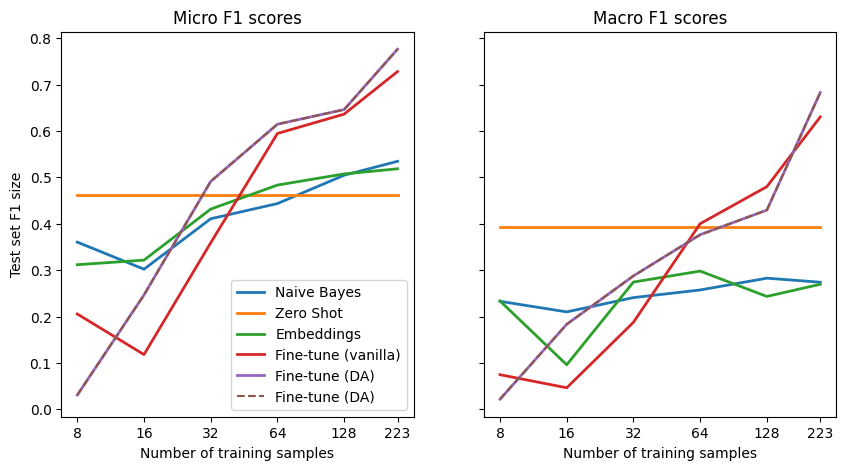

In [ ]:
#comparing the results

plot_metrics(micro_scores, macro_scores, train_samples, "Fine-tune (DA)")